# Jo Pipeline und so

In [2]:
import CONST

import numpy as np
import os, sys
from scipy import signal

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd

import pandas as pd
from numba import jit
from CONST import calculate_ann
from CONST import get_wav
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd
import pandas as pd
from numba import jit


sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
import libfmp.c6

%matplotlib inline


import librosa
import IPython.display as ipd

## Import Data

In [3]:
import os

folder = "own_music_data"

file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


audios = {file.split(".")[0]:get_wav(None, file) for file in file_names}




In [4]:
x, Fs = audios["01 Main Theme (Aberration)"]
#ipd.display(ipd.Audio(x, rate=Fs))

# SSM
## Chroma-Based SSM

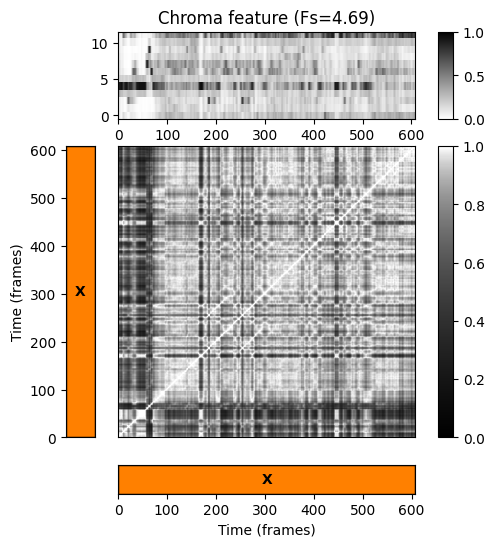

In [5]:
@jit(nopython=True)
def compute_sm_dot(X, Y):
    """Computes similarty matrix from feature sequences using dot (inner) product

    Notebook: C4/C4S2_SSM.ipynb

    Args:
        X (np.ndarray): First sequence
        Y (np.ndarray): Second Sequence

    Returns:
        S (float): Dot product
    """
    S = np.dot(np.transpose(X), Y)
    return S

def plot_feature_ssm(X, Fs_X, S, Fs_S, ann=None, duration=None, color_ann=None,
                     title='', label='Time (seconds)', time=True,
                     figsize=(5, 6), fontsize=10, clim_X=None, clim=None):
    """Plot SSM along with feature representation and annotations (standard setting is time in seconds)

    Notebook: C4/C4S2_SSM.ipynb

    Args:
        X: Feature representation
        Fs_X: Feature rate of ``X``
        S: Similarity matrix (SM)
        Fs_S: Feature rate of ``S``
        ann: Annotaions
        duration: Duration
        color_ann: Color annotations (see :func:`libfmp.b.b_plot.plot_segments`) (Default value = None)
        title: Figure title (Default value = '')
        label: Label for time axes (Default value = 'Time (seconds)')
        time: Display time axis ticks or not (Default value = True)
        figsize: Figure size (Default value = (5, 6))
        fontsize: Font size (Default value = 10)
        clim_X: Color limits for matrix X (Default value = None)
        clim: Color limits for matrix ``S`` (Default value = None)

    Returns:
        fig: Handle for figure
        ax: Handle for axes
    """
    cmap = libfmp.b.compressed_gray_cmap(alpha=10, reverse=True)
    fig, ax = plt.subplots(3, 3, gridspec_kw={'width_ratios': [0.1, 1, 0.05],
                                              'wspace': 0.2,
                                              'height_ratios': [0.3, 1, 0.1]},
                           figsize=figsize)
    libfmp.b.plot_matrix(X, Fs=Fs_X, ax=[ax[0, 1], ax[0, 2]], clim=clim_X,
                         xlabel='', ylabel='', title=title)
    ax[0, 0].axis('off')
    libfmp.b.plot_matrix(S, Fs=Fs_S, ax=[ax[1, 1], ax[1, 2]], cmap=cmap, clim=clim,
                         title='', xlabel='', ylabel='', colorbar=True)
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    libfmp.b.plot_segments(ann, ax=ax[2, 1], time_axis=time, fontsize=fontsize,
                           colors=color_ann,
                           time_label=label, time_max=duration*Fs_X)
    ax[2, 2].axis('off')
    ax[2, 0].axis('off')
    libfmp.b.plot_segments(ann, ax=ax[1, 0], time_axis=time, fontsize=fontsize,
                           direction='vertical', colors=color_ann,
                           time_label=label, time_max=duration*Fs_X)
    return fig, ax

# Waveform
# x, Fs = audios["weg-muss-sein-weil-studium"]
x_duration = (x.shape[0])/Fs

# Chroma Feature Sequence
N, H = 4096, 1024
chromagram = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(chromagram, Fs/H, filt_len=41, down_sampling=10)


# Annotation
# filename = 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
# fn_ann = os.path.join('..', 'data', 'C4', filename)
# ann, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename)
ann, color_ann, x_duration = calculate_ann(x, Fs)
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)


# SSM
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = compute_sm_dot(X,X)

fig, ax = plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
                           color_ann=color_ann, clim_X=[0,1], clim=[0,1],
                           label='Time (frames)', title='Chroma feature (Fs=%0.2f)'%Fs_X)

## MFCC-Based SSM


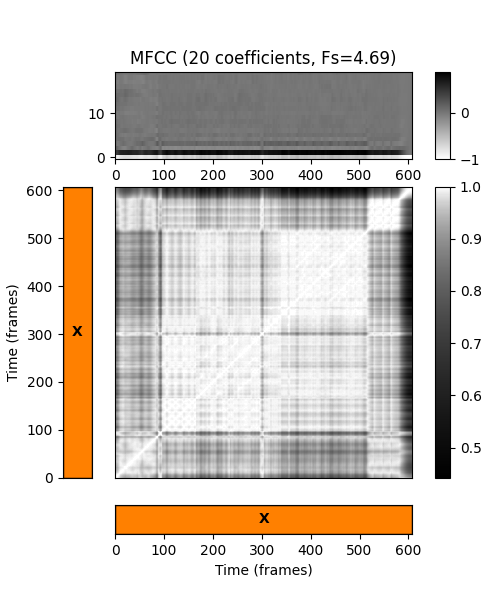
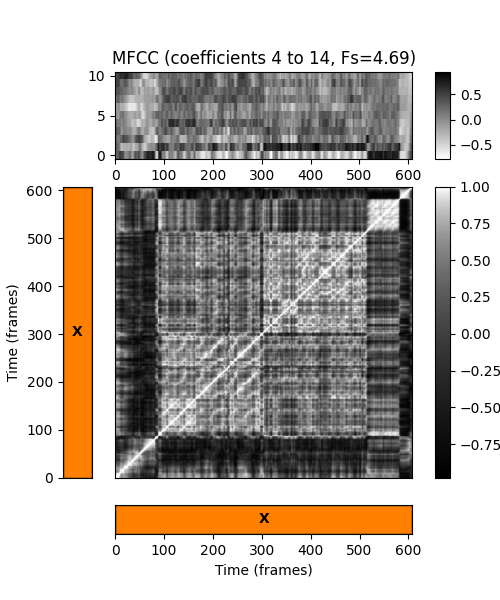

In [6]:
from libfmp.b import FloatingBox
float_box = libfmp.b.FloatingBox()

#x, Fs = audios["weg-muss-sein-weil-studium"]


# MFCC-based feature sequence
N, H = 2048, 1024
X_MFCC = librosa.feature.mfcc(y=x, sr=Fs, hop_length=H, n_fft=N)
coef = np.arange(0,20)
X_MFCC_upper = X_MFCC[coef,:]
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(X_MFCC_upper, Fs/H, filt_len=41, down_sampling=10)
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = compute_sm_dot(X,X)
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X, color_ann=color_ann,
    title='MFCC (20 coefficients, Fs=%0.2f)'%Fs_X, label='Time (frames)')
float_box.add_fig(fig)


# MFCC-based feature sequence only using coefficients 4 to 14
coef = np.arange(4,15)
X_MFCC_upper = X_MFCC[coef,:]
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(X_MFCC_upper, Fs/H, filt_len=41, down_sampling=10)
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = compute_sm_dot(X,X)
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X)
fig, ax = plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
                           color_ann=color_ann, label='Time (frames)',
                           title='MFCC (coefficients 4 to 14, Fs=%0.2f)'%Fs_X)
float_box.add_fig(fig)

float_box.show()

# Transposition Invariance


In [ ]:
from matplotlib.colors import ListedColormap

@jit(nopython=True)
def shift_cyc_matrix(X, shift=0):
    """Cyclic shift of features matrix along first dimension

    Notebook: C4/C4S2_SSM-TranspositionInvariance.ipynb

    Args:
        X (np.ndarray): Feature respresentation
        shift (int): Number of bins to be shifted (Default value = 0)

    Returns:
        X_cyc (np.ndarray): Cyclically shifted feature matrix
    """
    # Note: X_cyc = np.roll(X, shift=shift, axis=0) does to work for jit
    K, N = X.shape
    shift = np.mod(shift, K)
    X_cyc = np.zeros((K, N))
    X_cyc[shift:K, :] = X[0:K-shift, :]
    X_cyc[0:shift, :] = X[K-shift:K, :]
    return X_cyc


def compute_sm_ti(X, Y, L=1, tempo_rel_set=np.asarray([1]), shift_set=np.asarray([0]), direction=2):
    """Compute enhanced similaity matrix by applying path smoothing and transpositions

    Notebook: C4/C4S2_SSM-TranspositionInvariance.ipynb

    Args:
        X (np.ndarray): First feature sequence
        Y (np.ndarray): Second feature sequence
        L (int): Length of filter (Default value = 1)
        tempo_rel_set (np.ndarray): Set of relative tempo values (Default value = np.asarray([1]))
        shift_set (np.ndarray): Set of shift indices (Default value = np.asarray([0]))
        direction (int): Direction of smoothing (0: forward; 1: backward; 2: both directions) (Default value = 2)

    Returns:
        S_TI (np.ndarray): Transposition-invariant SM
        I_TI (np.ndarray): Transposition index matrix
    """
    for shift in shift_set:
        Y_cyc = shift_cyc_matrix(Y, shift)
        S_cyc = libfmp.c4.compute_sm_dot(X, Y_cyc)

        if direction == 0:
            S_cyc = libfmp.c4.filter_diag_mult_sm(S_cyc, L, tempo_rel_set, direction=0)
        if direction == 1:
            S_cyc = libfmp.c4.filter_diag_mult_sm(S_cyc, L, tempo_rel_set, direction=1)
        if direction == 2:
            S_forward = libfmp.c4.filter_diag_mult_sm(S_cyc, L, tempo_rel_set=tempo_rel_set, direction=0)
            S_backward = libfmp.c4.filter_diag_mult_sm(S_cyc, L, tempo_rel_set=tempo_rel_set, direction=1)
            S_cyc = np.maximum(S_forward, S_backward)
        if shift == shift_set[0]:
            S_TI = S_cyc
            I_TI = np.ones((S_cyc.shape[0], S_cyc.shape[1])) * shift
        else:
            # jit does not like the following lines
            # I_greater = np.greater(S_cyc, S_TI)
            # I_greater = (S_cyc > S_TI)
            I_TI[S_cyc > S_TI] = shift
            S_TI = np.maximum(S_cyc, S_TI)

    return S_TI, I_TI

def subplot_matrix_ti_colorbar(S, fig, ax, title='', Fs=1, xlabel='Time (seconds)', ylabel='Time (seconds)',
                               clim=None, xlim=None, ylim=None, cmap=None, alpha=1, interpolation='nearest',
                               ind_zero=False):
    """Visualization function for showing transposition index matrix

    Notebook: C4/C4S2_SSM-TranspositionInvariance.ipynb

    Args:
        S: Self-similarity matrix (SSM)
        fig: Figure handle
        ax: Axes handle
        title: Title for figure (Default value = '')
        Fs: Feature rate (Default value = 1)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Time (seconds)')
        clim: Color limits (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        cmap: Color map (Default value = None)
        alpha: Alpha value for imshow (Default value = 1)
        interpolation: Interpolation value for imshow (Default value = 'nearest')
        ind_zero: Use white (True) or black (False) color for index zero (Default value = False)

    Returns:
        im: Imshow handle
    """
    if cmap is None:
        color_ind_zero = np.array([0, 0, 0, 1])
        if ind_zero == 0:
            color_ind_zero = np.array([0, 0, 0, 1])
        else:
            color_ind_zero = np.array([1, 1, 1, 1])
        colorList = np.array([color_ind_zero, [1, 1, 0, 1],  [0, 0.7, 0, 1],  [1, 0, 1, 1],  [0, 0, 1, 1],
                             [1, 0, 0, 1], [0, 0, 0, 0.5], [1, 0, 0, 0.3], [0, 0, 1, 0.3], [1, 0, 1, 0.3],
                             [0, 0.7, 0, 0.3], [1, 1, 0, 0.3]])
        cmap = ListedColormap(colorList)
    len_sec = S.shape[0] / Fs
    extent = [0, len_sec, 0, len_sec]
    im = ax.imshow(S, aspect='auto', extent=extent, cmap=cmap,  origin='lower', alpha=alpha,
                   interpolation=interpolation)
    if clim is None:
        im.set_clim(vmin=-0.5, vmax=11.5)
    fig.sca(ax)
    ax_cb = fig.colorbar(im)
    ax_cb.set_ticks(np.arange(0, 12, 1))
    ax_cb.set_ticklabels(np.arange(0, 12, 1))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    return im

#x, Fs = audios["weg-muss-sein-weil-studium"]

L = 8
tempo_rel_set = np.asarray([1])
shift_set = np.array(range(12))
###################################
# ACHTUNG X VON OBEN
###################################
S_TI, I_TI = compute_sm_ti(X, X, L=L, tempo_rel_set=tempo_rel_set,
                           shift_set=shift_set, direction=2)

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
libfmp.c4.subplot_matrix_colorbar(S_TI, fig, ax[0], clim=[0.5,1],
                                  title='Transposition-invariant SSM')
subplot_matrix_ti_colorbar(I_TI, fig, ax[1], ind_zero=True,
                                  title='Transposition index matrix')
plt.tight_layout()
plt.show()

In [ ]:
#x, Fs = audios["weg-muss-sein-weil-studium"]

C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=2205, n_fft=4410)
Fs_C = Fs/2205

L_feature = 41
H_feature = 10
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(C, Fs_C,
                                    filt_len=L_feature, down_sampling=H_feature)
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)

tempo_rel_min = 0.66
tempo_rel_max = 1.5
num = 5
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(tempo_rel_min=tempo_rel_min, tempo_rel_max=tempo_rel_max, num=num)

shift_set = np.array(range(12))

L_set = [1, 20]
L_num = len(L_set)
title_set = ['Transposition-invariant SSM', 'Smoothed transposition-invariant SSM']

fig, ax = plt.subplots(L_num, 2, figsize=(8, 7))
for m in range(L_num):
    L = L_set[m]
    S_TI, I_TI = compute_sm_ti(X, X, L=L, tempo_rel_set=tempo_rel_set, shift_set=shift_set, direction=2)
    libfmp.c4.subplot_matrix_colorbar(S_TI, fig, ax[m,0], clim=[0.5,1],
                                  title=title_set[m])
    subplot_matrix_ti_colorbar(I_TI, fig, ax[m,1], ind_zero=True,
                                  title='Transposition index matrix')
plt.tight_layout()
plt.show()

# PATH SMOOTHING? Maybe if birds are better musicians

# Audio Thumbnailing

In [ ]:
@jit(nopython=True)
def compute_accumulated_score_matrix(S_seg):
    """Compute the accumulated score matrix

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S_seg (np.ndarray): Submatrix of an enhanced and normalized SSM ``S``.
            Note: ``S`` must satisfy ``S(n,m) <= 1 and S(n,n) = 1``

    Returns:
        D (np.ndarray): Accumulated score matrix
        score (float): Score of optimal path family
    """
    inf = math.inf
    N = S_seg.shape[0]
    M = S_seg.shape[1]+1

    # Iinitializing score matrix
    D = -inf * np.ones((N, M), dtype=np.float64)
    D[0, 0] = 0.
    D[0, 1] = D[0, 0] + S_seg[0, 0]

    # Dynamic programming
    for n in range(1, N):
        D[n, 0] = max(D[n-1, 0], D[n-1, -1])
        D[n, 1] = D[n, 0] + S_seg[n, 0]
        for m in range(2, M):
            D[n, m] = S_seg[n, m-1] + max(D[n-1, m-1], D[n-1, m-2], D[n-2, m-1])

    # Score of optimal path family
    score = np.maximum(D[N-1, 0], D[N-1, M-1])

    return D, score

In [ ]:
import math


@jit(nopython=True)
def compute_optimal_path_family(D):
    """Compute an optimal path family given an accumulated score matrix

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        D (np.ndarray): Accumulated score matrix

    Returns:
        path_family (list): Optimal path family consisting of list of paths
            (each path being a list of index pairs)
    """
    # Initialization
    inf = math.inf
    N = int(D.shape[0])
    M = int(D.shape[1])

    path_family = []
    path = []

    n = N - 1
    if(D[n, M-1] < D[n, 0]):
        m = 0
    else:
        m = M-1
        path_point = (N-1, M-2)
        path.append(path_point)

    # Backtracking
    while n > 0 or m > 0:

        # obtaining the set of possible predecesors given our current position
        if(n <= 2 and m <= 2):
            predecessors = [(n-1, m-1)]
        elif(n <= 2 and m > 2):
            predecessors = [(n-1, m-1), (n-1, m-2)]
        elif(n > 2 and m <= 2):
            predecessors = [(n-1, m-1), (n-2, m-1)]
        else:
            predecessors = [(n-1, m-1), (n-2, m-1), (n-1, m-2)]

        # case for the first row. Only horizontal movements allowed
        if n == 0:
            cell = (0, m-1)
        # case for the elevator column: we can keep going down the column or jumping to the end of the next row
        elif m == 0:
            if D[n-1, M-1] > D[n-1, 0]:
                cell = (n-1, M-1)
                path_point = (n-1, M-2)
                if(len(path) > 0):
                    path.reverse()
                    path_family.append(path)
                path = [path_point]
            else:
                cell = (n-1, 0)
        # case for m=1, only horizontal steps to the elevator column are allowed
        elif m == 1:
            cell = (n, 0)
        # regular case
        else:

            # obtaining the best of the possible predecesors
            max_val = -inf
            for i, cur_predecessor in enumerate(predecessors):
                if(max_val < D[cur_predecessor[0], cur_predecessor[1]]):
                    max_val = D[cur_predecessor[0], cur_predecessor[1]]
                    cell = cur_predecessor

            # saving the point in the current path
            path_point = (cell[0], cell[1]-1)
            path.append(path_point)

        (n, m) = cell

    # adding last path to the path family
    path.reverse()
    path_family.append(path)
    path_family.reverse()

    return path_family

In [ ]:
def compute_induced_segment_family_coverage(path_family):
    """Compute induced segment family and coverage from path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        path_family (list): Path family

    Returns:
        segment_family (np.ndarray): Induced segment family
        coverage (float): Coverage of path family
    """
    num_path = len(path_family)
    coverage = 0
    if num_path > 0:
        segment_family = np.zeros((num_path, 2), dtype=int)
        for n in range(num_path):
            segment_family[n, 0] = path_family[n][0][0]
            segment_family[n, 1] = path_family[n][-1][0]
            coverage = coverage + segment_family[n, 1] - segment_family[n, 0] + 1
    else:
        segment_family = np.empty

    return segment_family, coverage

In [ ]:
def compute_fitness(path_family, score, N):
    """Compute fitness measure and other metrics from path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        path_family (list): Path family
        score (float): Score
        N (int): Length of feature sequence

    Returns:
        fitness (float): Fitness
        score (float): Score
        score_n (float): Normalized score
        coverage (float): Coverage
        coverage_n (float): Normalized coverage
        path_family_length (int): Length of path family (total number of cells)
    """
    eps = 1e-16
    num_path = len(path_family)
    M = path_family[0][-1][1] + 1

    # Normalized score
    path_family_length = 0
    for n in range(num_path):
        path_family_length = path_family_length + len(path_family[n])
    score_n = (score - M) / (path_family_length + eps)

    # Normalized coverage
    segment_family, coverage = compute_induced_segment_family_coverage(path_family)
    coverage_n = (coverage - M) / (N + eps)

    # Fitness measure
    fitness = 2 * score_n * coverage_n / (score_n + coverage_n + eps)

    return fitness, score, score_n, coverage, coverage_n, path_family_length

N = S.shape[0]


In [ ]:
def plot_ssm_ann(S, ann, Fs=1, cmap='gray_r', color_ann=[], ann_x=True, ann_y=True,
                 fontsize=12, figsize=(5, 4.5), xlabel='', ylabel='', title=''):
    """Plot SSM and annotations (horizontal and vertical as overlay)

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S: Self-similarity matrix
        ann: Annotations
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        ann_x: Plot annotations on x-axis (Default value = True)
        ann_y: Plot annotations on y-axis (Default value = True)
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        xlabel: Label for x-axis (Default value = '')
        ylabel: Label for y-axis (Default value = '')
        title: Figure size (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05],
                                              'height_ratios': [1, 0.1]}, figsize=figsize)

    fig_im, ax_im, im = libfmp.b.plot_matrix(S, Fs=Fs, Fs_F=Fs,
                                             ax=[ax[0, 0], ax[0, 1]], cmap=cmap,
                                             xlabel='', ylabel='', title='')
    ax[0, 0].set_ylabel(ylabel)
    ax[0, 0].set_xlabel(xlabel)
    ax[0, 0].set_title(title)
    if ann_y:
        libfmp.b.plot_segments_overlay(ann, ax=ax_im[0], direction='vertical',
                                       time_max=S.shape[0]/Fs, print_labels=False,
                                       colors=color_ann, alpha=0.05)
    if ann_x:
        libfmp.b.plot_segments(ann, ax=ax[1, 0], time_max=S.shape[0]/Fs, colors=color_ann,
                               time_axis=False, fontsize=fontsize)
    else:
        ax[1, 0].axis('off')
    ax[1, 1].axis('off')
    plt.tight_layout()
    return fig, ax, im


In [ ]:
def plot_path_family(ax, path_family, Fs=1, x_offset=0, y_offset=0, proj_x=True, w_x=7, proj_y=True, w_y=7):
    """Plot path family into a given axis

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        ax: Axis of plot
        path_family: Path family
        Fs: Feature rate of path_family (Default value = 1)
        x_offset: Offset x-axis (Default value = 0)
        y_offset: Yffset x-axis (Default value = 0)
        proj_x: Display projection on x-axis (Default value = True)
        w_x: Width used for projection on x-axis (Default value = 7)
        proj_y: Display projection on y-axis (Default value = True)
        w_y: Width used for projection on y-axis (Default value = 7)
    """
    for path in path_family:
        y = [(path[i][0] + y_offset)/Fs for i in range(len(path))]
        x = [(path[i][1] + x_offset)/Fs for i in range(len(path))]
        ax.plot(x, y, "o", color=[0, 0, 0], linewidth=3, markersize=5)
        ax.plot(x, y, '.', color=[0.7, 1, 1], linewidth=2, markersize=6)
    if proj_y:
        for path in path_family:
            y1 = path[0][0]/Fs
            y2 = path[-1][0]/Fs
            ax.add_patch(plt.Rectangle((0, y1), w_y, y2-y1, linewidth=1,
                                       facecolor=[0, 1, 0], edgecolor=[0, 0, 0]))
            # ax.plot([0, 0], [y1, y2], linewidth=8, color=[0, 1, 0])
    if proj_x:
        for path in path_family:
            x1 = (path[0][1] + x_offset)/Fs
            x2 = (path[-1][1] + x_offset)/Fs
            ax.add_patch(plt.Rectangle((x1, 0), x2-x1, w_x, linewidth=1,
                                       facecolor=[0, 0, 1], edgecolor=[0, 0, 0]))

In [9]:
def colormap_penalty(penalty=-2, cmap=libfmp.b.compressed_gray_cmap(alpha=5)):
    """Extend colormap with white color between the penalty value and zero

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        penalty (float): Negative number (Default value = -2.0)
        cmap (mpl.colors.Colormap): Original colormap (Default value = libfmp.b.compressed_gray_cmap(alpha=5))

    Returns:
        cmap_penalty (mpl.colors.Colormap): Extended colormap
    """
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 128)
    cmap_matrix = cmap(np.linspace(0, 1, 128))[:, :3]
    num_row = int(np.abs(penalty)*128)
    # cmap_penalty = np.flip(np.concatenate((cmap_matrix, np.ones((num_row, 3))), axis=0), axis=0)
    cmap_penalty = np.concatenate((np.ones((num_row, 3)), cmap_matrix), axis=0)
    cmap_penalty = ListedColormap(cmap_penalty)

    return cmap_penalty

In [8]:
def plot_ssm_ann_optimal_path_family(S, ann, seg, Fs=1, cmap='gray_r', color_ann=[], fontsize=12,
                                     figsize=(5, 4.5), ylabel=''):
    """Plot SSM, annotations, and computed optimal path family

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S: Self-similarity matrix
        ann: Annotations
        seg: Segment for computing the optimal path family
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        ylabel: Label for y-axis (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = compute_accumulated_score_matrix(S_seg)
    path_family = compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
        path_family, score, N)
    title = r'$\bar{\sigma}(\alpha)=%0.2f$, $\bar{\gamma}(\alpha)=%0.2f$, $\varphi(\alpha)=%0.2f$' % \
            (score_n, coverage_n, fitness)
    fig, ax, im = plot_ssm_ann(S, ann, color_ann=color_ann, Fs=Fs, cmap=cmap,
                               figsize=figsize, fontsize=fontsize,
                               xlabel=r'$\alpha=[%d:%d]$' % (seg[0], seg[-1]), ylabel=ylabel, title=title)
    plot_path_family(ax[0, 0], path_family, Fs=Fs, x_offset=seg[0])
    return fig, ax, im

SP_all = libfmp.c4.compute_fitness_scape_plot(S)
SP = SP_all[0]
seg = libfmp.c4.seg_max_sp(SP)
penalty = -2
cmap_penalty = colormap_penalty(penalty=penalty)



fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,
                    color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
plt.show()
path_family = libfmp.c4.check_segment(seg, S)

NameError: name 'colormap_penalty' is not defined

# Scape Plot

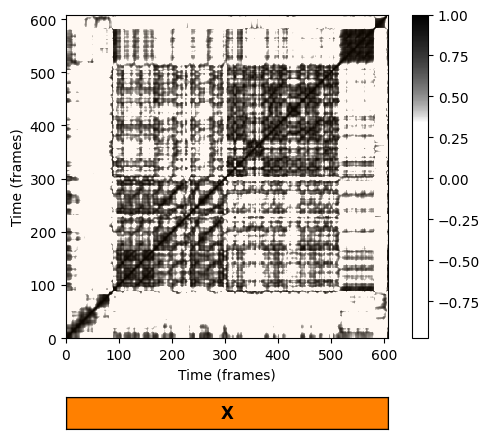

In [10]:
cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
fig, ax, im = libfmp.c4.plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty,
                       xlabel='Time (frames)', ylabel='Time (frames)')

In [11]:
# @jit(nopython=True)
def compute_fitness_scape_plot(S):
    """Compute scape plot for fitness and other measures

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix

    Returns:
        SP_all (np.ndarray): Vector containing five different scape plots for five measures
            (fitness, score, normalized score, coverage, normlized coverage)
    """
    N = S.shape[0]
    SP_fitness = np.zeros((N, N))
    SP_score = np.zeros((N, N))
    SP_score_n = np.zeros((N, N))
    SP_coverage = np.zeros((N, N))
    SP_coverage_n = np.zeros((N, N))

    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            S_seg = S[:, start:start+length_minus_one+1]
            D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
            path_family = libfmp.c4.compute_optimal_path_family(D)
            fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
                path_family, score, N)
            SP_fitness[length_minus_one, start] = fitness
            SP_score[length_minus_one, start] = score
            SP_score_n[length_minus_one, start] = score_n
            SP_coverage[length_minus_one, start] = coverage
            SP_coverage_n[length_minus_one, start] = coverage_n
    SP_all = [SP_fitness, SP_score, SP_score_n, SP_coverage, SP_coverage_n]
    return SP_all

In [12]:
def visualize_scape_plot(SP, Fs=1, ax=None, figsize=(4, 3), title='',
                         xlabel='Center (seconds)', ylabel='Length (seconds)', interpolation='nearest'):
    """Visualize scape plot

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot data (encodes as start-duration matrix)
        Fs: Sampling rate (Default value = 1)
        ax: Used axes (Default value = None)
        figsize: Figure size (Default value = (4, 3))
        title: Title of figure (Default value = '')
        xlabel: Label for x-axis (Default value = 'Center (seconds)')
        ylabel: Label for y-axis (Default value = 'Length (seconds)')
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
    N = SP.shape[0]
    SP_vis = np.zeros((N, N))
    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            center = start + length_minus_one//2
            SP_vis[length_minus_one, center] = SP[length_minus_one, start]

    extent = np.array([-0.5, (N-1)+0.5, -0.5, (N-1)+0.5]) / Fs
    im = plt.imshow(SP_vis, cmap='hot_r', aspect='auto', origin='lower', extent=extent, interpolation=interpolation)
    x = np.asarray(range(N))
    x_half_lower = x/2
    x_half_upper = x/2 + N/2 - 1/2
    plt.plot(x_half_lower/Fs, x/Fs, '-', linewidth=3, color='black')
    plt.plot(x_half_upper/Fs, np.flip(x, axis=0)/Fs, '-', linewidth=3, color='black')
    plt.plot(x/Fs, np.zeros(N)/Fs, '-', linewidth=3, color='black')
    plt.xlim([0, (N-1) / Fs])
    plt.ylim([0, (N-1) / Fs])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.colorbar(im, ax=ax)
    return fig, ax, im

def plot_seg_in_sp(ax, seg, S=None, Fs=1):
    """Plot segment and induced segements as points in SP visualization

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        ax: Axis for image
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix (Default value = None)
        Fs: Sampling rate (Default value = 1)
    """
    if S is not None:
        S_seg = S[:, seg[0]:seg[1]+1]
        D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
        path_family = libfmp.c4.compute_optimal_path_family(D)
        segment_family, coverage = libfmp.c4.compute_induced_segment_family_coverage(path_family)
        length = segment_family[:, 1] - segment_family[:, 0] + 1
        center = segment_family[:, 0] + length//2
        ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
        ax.scatter(center/Fs, length/Fs, s=16, c='lime', zorder=9999)
    length = seg[1] - seg[0] + 1
    center = seg[0] + length//2
    ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
    ax.scatter(center/Fs, length/Fs, s=16, c='blue', zorder=9999)

In [13]:
def plot_sp_ssm(SP, seg, S, ann, color_ann=[], title='', figsize=(5, 4)):
    """Visulization of SP and SSM

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix
        ann: Annotation
        color_ann: color scheme used for annotations (Default value = [])
        title: Title of figure (Default value = '')
        figsize: Figure size (Default value = (5, 4))
    """
    float_box = libfmp.b.FloatingBox()
    fig, ax, im = visualize_scape_plot(SP, figsize=figsize, title=title,
                                       xlabel='Center (frames)', ylabel='Length (frames)')
    plot_seg_in_sp(ax, seg, S)
    float_box.add_fig(fig)

    penalty = np.min(S)
    cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
    fig, ax, im = libfmp.c4.plot_ssm_ann_optimal_path_family(
        S, ann, seg, color_ann=color_ann, fontsize=8, cmap=cmap_penalty, figsize=(4, 4),
        ylabel='Time (frames)')
    float_box.add_fig(fig)
    float_box.show()

def check_segment(seg, S):
    """Prints properties of segments with regard to SSM ``S``

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        seg (tuple): Segment ``(start_index, end_index)``
        S (np.ndarray): Self-similarity matrix

    Returns:
         path_family (list): Optimal path family
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
    path_family = libfmp.c4.compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
                path_family, score, N)
    segment_family, coverage2 = libfmp.c4.compute_induced_segment_family_coverage(path_family)
    print('Segment (alpha):', seg)
    print('Length of segment:', seg[-1]-seg[0]+1)
    print('Length of feature sequence:', N)
    print('Induced segment path family:\n', segment_family)
    print('Fitness: %0.10f' % fitness)
    print('Score: %0.10f' % score)
    print('Normalized score: %0.10f' % score_n)
    print('Coverage: %d, %d' % (coverage, coverage2))
    print('Normalized coverage: %0.10f' % coverage_n)
    print('Length of all paths of family: %d' % path_family_length)
    return path_family


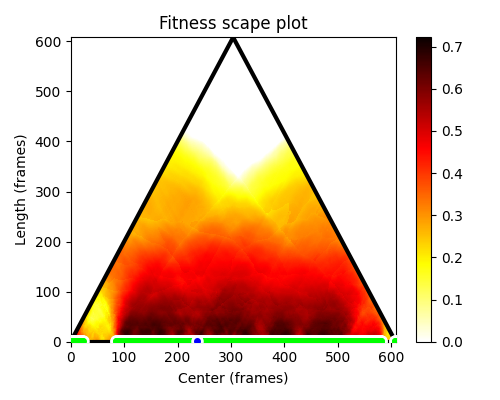
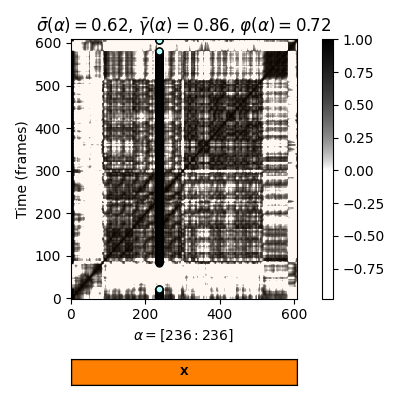

Segment (alpha): [236, 236]
Length of segment: 1
Length of feature sequence: 609
Induced segment path family:
 [[  0   0]
 [  1   1]
 [  2   2]
 ...
 [606 606]
 [607 607]
 [608 608]]
Fitness: 0.7218304282
Score: 327.2159525438
Normalized score: 0.6225495278
Coverage: 524, 524
Normalized coverage: 0.8587848933
Length of all paths of family: 524


In [14]:
SP_all = compute_fitness_scape_plot(S)
figsize=(5,4)
SP = SP_all[0]
seg = libfmp.c4.seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann,
            title='Fitness scape plot', figsize=figsize)
path_family = check_segment(seg, S)